In [1]:
# !pip install rho_plus
# !pip install statsmodels
# !pip install mendeleev
# !pip install pymatgen

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rho_plus as rp

# if you want dark mode, use is_dark=True instead
theme, cs = rp.mpl_setup(is_dark=False)

# context='talk' makes the text big so it's easy to see
# for your work, you may want to set this to 'notebook' instead
sns.set_context('notebook')

In [264]:
feats = pd.read_csv('custom_features.csv', index_col=0)


for col in feats.columns:
    if feats[col].dtype == 'object':
        feats[col] = feats[col].astype('category')


X = feats
# X = pd.read_feather('cfid_features.feather')                               # all of the Jarvis features
# X = pd.concat([pd.read_feather('cfid_features.feather'), feats], axis=1)   # the combination of
# the two


targets = pd.read_csv('targets.csv', index_col=0)
targets = targets.set_index('CSD_code')
targets['Fermi'] = targets.eval('(HOMO_Energy + LUMO_Energy) / 2')

print('Possible targets:', list(targets.columns))

################ Multiple target columns exist.
# Try different columns to see what happens.
target_name = 'HL_Gap'
################

y = targets[target_name]

Possible targets: ['Electronic_E', 'Dispersion_E', 'Dipole_M', 'Metal_q', 'HL_Gap', 'HOMO_Energy', 'LUMO_Energy', 'Polarizability', 'Fermi']


In [265]:
import textwrap
print('\n'.join(textwrap.wrap(', '.join(feats.columns), width=150)))

metal_node_degree, nearest_neighbor_dist, average_dist, metal_atomic_number, metal_atomic_radius_rahm, metal_atomic_radius, metal_atomic_volume,
metal_block, metal_covalent_radius_bragg, metal_covalent_radius_cordero, metal_electron_affinity, metal_electronegativity_allen,
metal_electronegativity_martynov_batsanov, metal_electronegativity_mulliken, metal_electronegativity_sanderson, metal_electrophilicity, metal_group,
metal_hardness, metal_mendeleev_number, metal_metallic_radius, metal_metallic_radius_c12, metal_nvalence, metal_proton_affinity, metal_period,
metal_series, metal_softness, metal_symbol, metal_vdw_radius, metal_vdw_radius_bondi, metal_oxistate, metal_group_symbol, metal_ion_energy_1,
metal_ion_energy_2, metal_ion_energy_3, closest_neighbor_atomic_number, closest_neighbor_atomic_radius_rahm, closest_neighbor_atomic_radius,
closest_neighbor_atomic_volume, closest_neighbor_block, closest_neighbor_covalent_radius_bragg, closest_neighbor_covalent_radius_cordero,
closest_neigh

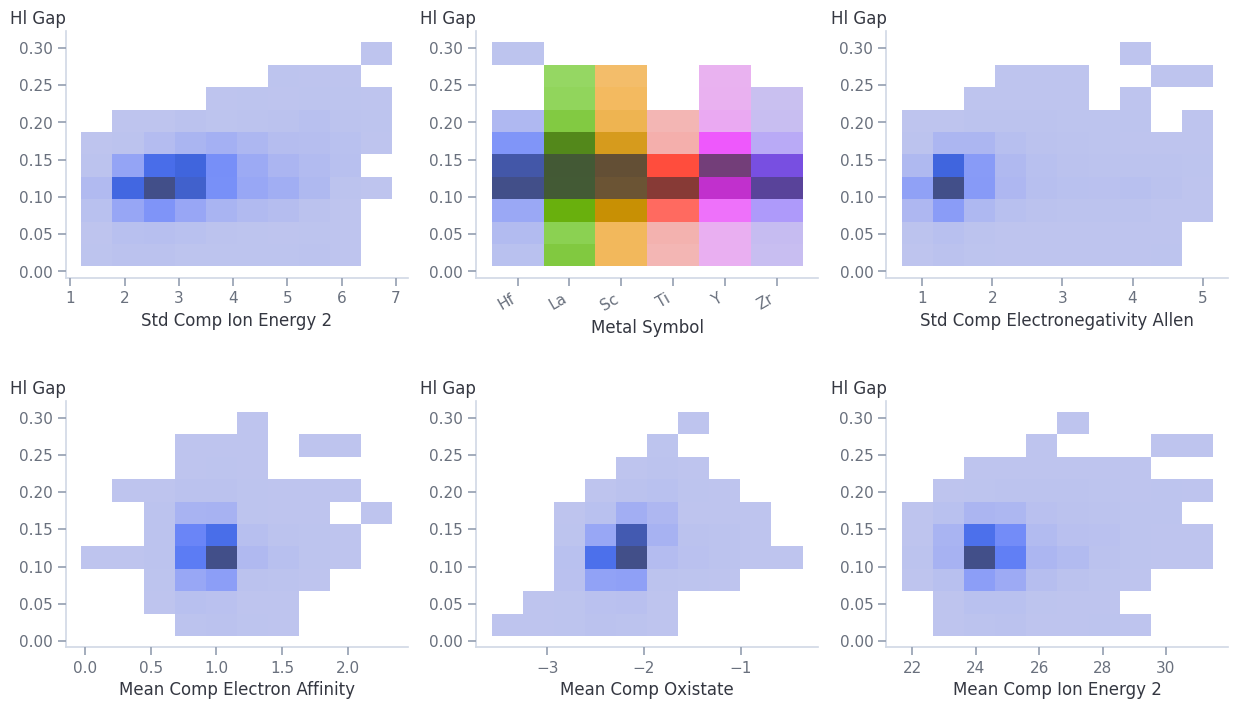

In [277]:
################# Create new features, if you want.
feats['dist_over_rad'] = feats.eval('nearest_neighbor_dist / metal_atomic_radius')
feats['electronegativity_diff'] = feats.eval('metal_electronegativity_mulliken / closest_neighbor_electronegativity_mulliken')
for col1 in feats.select_dtypes('number').columns:
    if col1.startswith('metal_') and col1 != 'metal_node_degree':
        prop = col1.removeprefix('metal_')
        feats[f'diff_{prop}'] = feats.eval(f'metal_{prop} - closest_neighbor_{prop}')
#################

X = feats[[
    ##################### Pick features to use.
    'std_comp_ion_energy_2',
    "metal_symbol",
    "std_comp_electronegativity_allen",
    "mean_comp_electron_affinity",
    "mean_comp_oxistate",
    "mean_comp_ion_energy_2"
    #####################
]]

fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False, gridspec_kw=dict(hspace=0.5))
for col, ax in zip(X.columns, axs.flatten()):
    if X.dtypes[col] == 'category':
        # categorical, use that
        sns.histplot(x=X[col], y=y.values, ax=ax, hue=X[col], legend=None, bins=10, common_norm=False)
        ax.set_xticks(ax.get_xticks())        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    else:
        # numerical
        sns.histplot(x=X[col], y=y.values, ax=ax, bins=10, common_norm=False)
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel(target_name.replace('_', ' ').title())
    rp.ylabel_top(ax=ax)        

In [278]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, d2_absolute_error_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

pipe = make_pipeline(    
    HistGradientBoostingRegressor(interaction_cst="pairwise", categorical_features='from_dtype')
)

pipe2 = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), selector(dtype_exclude="category")),
            ("cat", OneHotEncoder(), selector(dtype_include="category")),]),
    SimpleImputer(strategy='median'),
    LinearRegression())

yhat = cross_val_predict(pipe, X, y, cv=10)
yhat2 = cross_val_predict(pipe2, X, y, cv=10)
print('R2 Score (Gradient-Boosting):\t', f'{r2_score(y, yhat):6.2%}')
print('R2 Score (Linear Model):\t', f'{r2_score(y, yhat2):6.2%}')

R2 Score (Gradient-Boosting):	 34.81%
R2 Score (Linear Model):	 25.96%


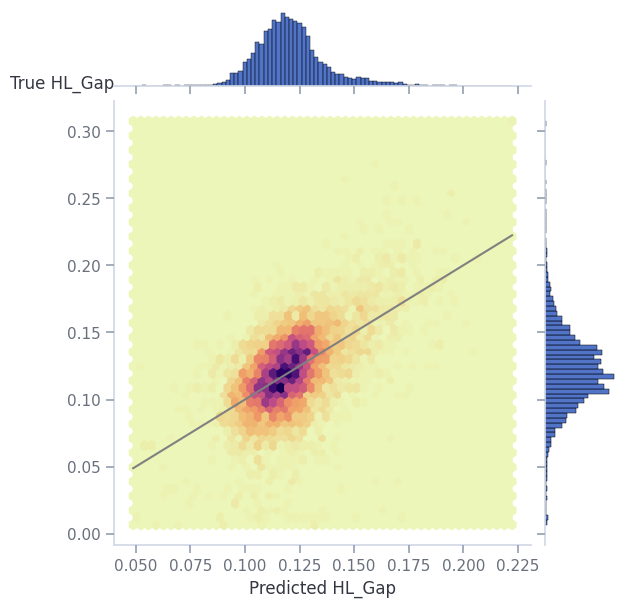

In [268]:
sns.jointplot(x=yhat, y=y, kind='hex', cmap='rho_heatmap')
plt.xlabel(f'Predicted {y.name}')
plt.ylabel(f'True {y.name}')
plt.plot((yhat.min(), yhat.max()), (yhat.min(), yhat.max()), color='gray', scalex=False, scaley=False)
rp.ylabel_top()